## Dataset
Dataset 1: Fer Dataset
Dataset 2: Fer+ Dataset
The new label file is named fer2013new.csv and contains the same number of rows as the original fer2013.csv label file with the same order, so that you infer which emotion tag belongs to which image.


## Importing Libraries


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import utils
from sklearn.utils import shuffle
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

# 01 Exploratory Data Analysis
Let's first take a look at what the data is like.

## Data Ingestion

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DRIVE_PATH = '/kaggle/input/sc1015-mini-project-data/'
DRIVE_PATH = '/content/drive/MyDrive/SC1015-Mini-Project-Data/'
DATA_NAME =  'fer2013.csv'
LABELS_NAME =  'fer2013new.csv'
DATA_PATH = os.path.join(DRIVE_PATH, DATA_NAME)
LABELS_PATH = os.path.join(DRIVE_PATH, LABELS_NAME)

In [ ]:
data = pd.read_csv(DATA_PATH)
labels = pd.read_csv(LABELS_PATH)

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
labels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [ ]:
# Create a new column for new label `new_emotion`
emotion_df = labels[labels.columns[2:]]
data['new_emotion'] = emotion_df.idxmax(axis=1)
data.head()

,emotion,pixels,Usage,new_emotion
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,neutral
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,neutral
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,neutral
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,neutral
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,neutral


In [ ]:
data['new_emotion'].value_counts()

new_emotion
neutral      12906
happiness     9355
surprise      4462
sadness       4371
anger         3111
fear           819
disgust        248
unknown        222
contempt       216
NF             177
Name: count, dtype: int64

## Check for NULL values

In [ ]:
data.isnull().any().sum()

0

In [ ]:
labels.isnull().any().sum()

1

## Visualising data

In [ ]:
# Display the counts for each emotion
emotion_counts = data['new_emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['Emotion', 'Number']
emotion_counts

,Emotion,Number
0,neutral,12906
1,sadness,4371
2,happiness,9355
3,surprise,4462
4,anger,3111
5,NF,177
6,fear,819
7,contempt,216
8,disgust,248
9,unknown,222


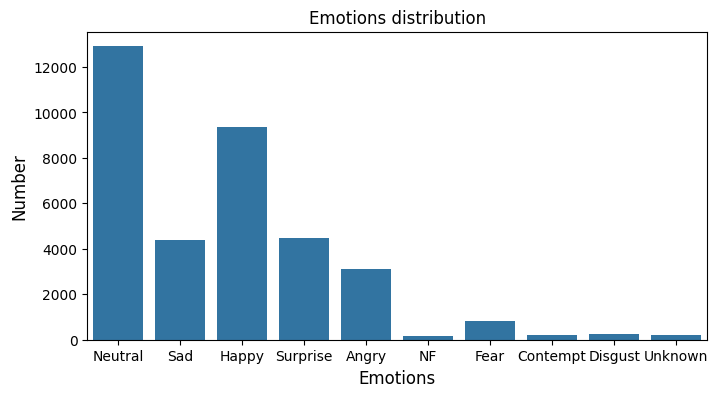

In [ ]:
# Visualise emotion data distribution
plt.figure(figsize=(8,4))
ax = sns.barplot(emotion_counts.Number)
plt.title('Emotions distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
ax.set_xticklabels(['Neutral', 'Sad', 'Happy', 'Surprise', 'Angry', 'NF', 'Fear', 'Contempt', 'Disgust', 'Unknown'])
plt.show()

In [ ]:
# Split data into Train, Test, and Validation sets
train_data = data.loc[data["Usage"] == "Training"]
test_data = data.loc[data["Usage"] == "PublicTest"]
validation_data = data.loc[data["Usage"] == "PrivateTest"]

print("Training shape = ", train_data.shape)
print("Testing shape = ", test_data.shape)
print("Validation shape = ", validation_data.shape)

Training shape =  (28709, 4)
Testing shape =  (3589, 4)
Validation shape =  (3589, 4)


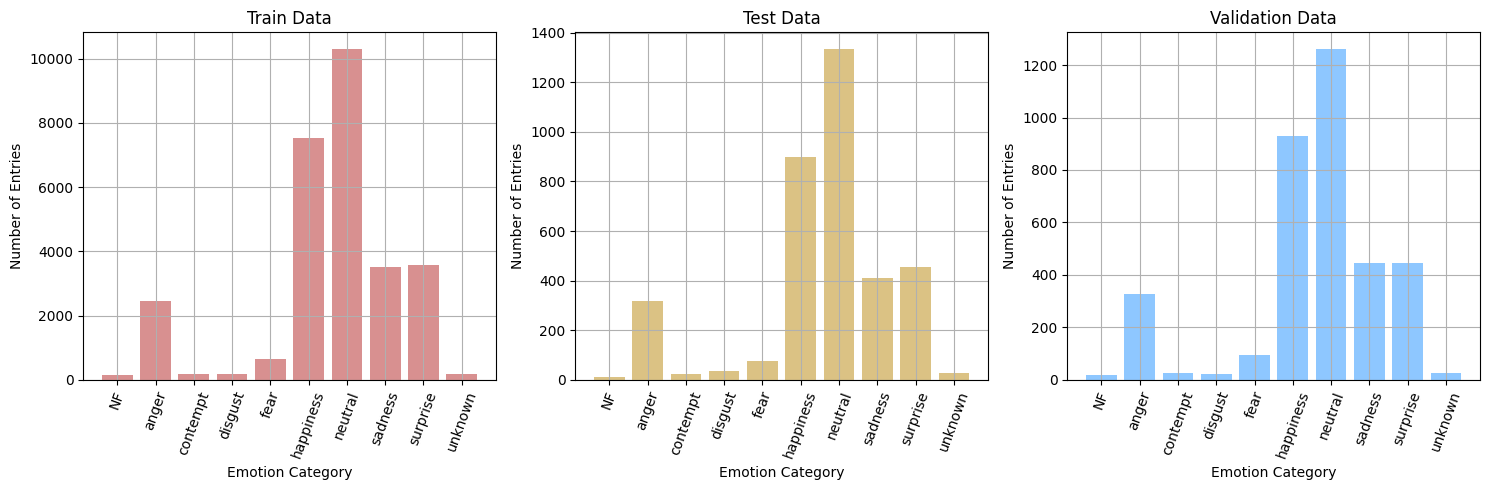

In [ ]:
# Convert to DataFrame
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
validation_df = pd.DataFrame(validation_data)

# Count emotions for each dataset
train_counts = train_df['new_emotion'].value_counts().sort_index()
test_counts = test_df['new_emotion'].value_counts().sort_index()
validation_counts = validation_df['new_emotion'].value_counts().sort_index()

# Plot each distribution in separate subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Train data
axes[0].bar(train_counts.index, train_counts.values, color='firebrick', alpha=0.5)
axes[0].set_title("Train Data")
axes[0].set_xlabel("Emotion Category")
axes[0].set_ylabel("Number of Entries")
axes[0].tick_params(axis='x', labelrotation=70)
axes[0].grid(True)

# Test data
axes[1].bar(test_counts.index, test_counts.values, color='darkgoldenrod', alpha=0.5)
axes[1].set_title("Test Data")
axes[1].set_xlabel("Emotion Category")
axes[1].set_ylabel("Number of Entries")
axes[1].tick_params(axis='x', labelrotation=70)
axes[1].grid(True)

# Validation data
axes[2].bar(validation_counts.index, validation_counts.values, color='dodgerblue', alpha=0.5)
axes[2].set_title("Validation Data")
axes[2].set_xlabel("Emotion Category")
axes[2].set_ylabel("Number of Entries")
axes[2].tick_params(axis='x', labelrotation=70)
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Insights from Barplot
* It seems like the data is imbalanced. Some classes have significantly more samples than others. For example, classes like happiness have 7215 samples, while disgust has only 436 samples.

* Imbalanced data can affect the performance of machine learning models, as they may become biased towards the majority class. Therefore, it's important to consider techniques such as oversampling.

* Oversampling is like adding more synthetic images to dataset.

* To address this Imbalanced data issue, I perform oversampling on the minority classes "disgust" and "surprise" using the Synthetic Minority Over-sampling Technique (SMOTE).

* SMOTE generates synthetic samples for the minority class by interpolating between existing samples. This helps to balance the class distribution and improves the model's ability to learn from the minority classes.

* Oversampling is a technique used to balance class distribution in imbalanced datasets by increasing the number of samples in minority classes through synthetic data generation or replication.

Possible actions:
* Identifying the indices of the minority classes ("contemp", "disgust" and "surprise").

* Resampling these classes using SMOTE to increase their sample count.
Concatenating the original data with the resampled data to create a balanced dataset.

* Selecting a specific number of samples from the resampled data for certain classes to control the balance and size of the dataset.

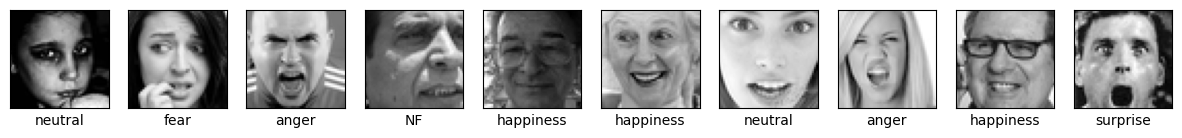

In [ ]:
# Add image and labels into array for display
image_array = []
labels = []
for row in range(20, 30):
    image = np.fromstring(train_df.loc[row, 'pixels'], dtype=int, sep=' ')
    image_array.append(image.flatten())
    labels.append(train_df.loc[row, 'new_emotion'])

# Set figure size to accommodate horizontally arranged images
plt.figure(figsize=(15, 2))

# Loop through the images and print horizontally with labels
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(image_array[i].reshape(48, 48), cmap='gray')
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    # Add labels below each image
    plt.xlabel(labels[i])

plt.show()

# 02 Data Preprocessing

In [ ]:
# Print unique emotion labels
print(data['new_emotion'].unique())

['neutral' 'sadness' 'happiness' 'surprise' 'anger' 'NF' 'fear' 'contempt'
 'disgust' 'unknown']


## Remove unuseful data

In [ ]:
# Drop unuseful rows (rows with emotion labelled as NF or unknown)
new_data = data[~data['new_emotion'].isin(['NF', 'unknown'])]
new_data.reset_index(drop=True, inplace=True)

In [ ]:
# Map emotions to numerical values
# Cannot have gap to perform ohe, so by ignoring NF: 5, fear will be 5 instead
# emotion_map = {'neutral': 0, 'sadness': 1, 'happiness': 2, 'surprise': 3, 'anger': 4, 'NF': 5, 'fear': 6, 'contempt': 7, 'disgust': 8, 'unknown': 9}
emotion_map = {'neutral': 0, 'sadness': 1, 'happiness': 2, 'surprise': 3, 'anger': 4, 'fear': 5, 'contempt': 6, 'disgust': 7}
new_data['new_emotion'] = new_data['new_emotion'].map(emotion_map)
new_data.head()

,emotion,pixels,Usage,new_emotion
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,0
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,0
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,0
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,0
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,0


## Data Oversampling

In [ ]:
# from imblearn.over_sampling import SMOTE

# # Identify the indices of "Contempt", "Disgust" and "Surprise" classes
# contempt_indices = np.where(train_labels == "contempt")[0]
# disgust_indices = np.where(train_labels == "disgust")[0]
# surprise_indices = np.where(train_labels == "surprise")[0]

# # Combine the indices of both classes
# indices_to_oversample = np.concatenate([contempt_indices, disgust_indices, surprise_indices])

# # Extract images and labels for the selected indices
# X_to_oversample = train_images[indices_to_oversample]
# y_to_oversample = train_labels[indices_to_oversample]

# # Reshape the images to 2D (if needed)
# X_to_oversample_2d = X_to_oversample.reshape(X_to_oversample.shape[0], -1)

# # Define the oversampling strategy
# oversample = SMOTE()

# # Apply SMOTE to the selected classes
# X_resampled, y_resampled = oversample.fit_resample(X_to_oversample_2d, y_to_oversample)

# # Reshape the oversampled data back to its original shape
# X_resampled = X_resampled.reshape(-1, *train_images.shape[1:])

# # Check the new class distribution
# unique, counts = np.unique(y_resampled, return_counts=True)
# print(dict(zip(unique, counts)))

In [ ]:
# # Filter oversampled data for "disgust" class
# disgust_resampled_indices = np.where(y_resampled == "disgust")[0]

# # Choose random samples from the original "disgust" data
# num_samples = 5
# random_original_indices = np.random.choice(disgust_indices, num_samples, replace=False)

# # Choose random samples from the oversampled data for "disgust" class
# num_oversampled = min(num_samples, len(disgust_resampled_indices))
# random_over_sample_indices = np.random.choice(disgust_resampled_indices, num_oversampled, replace=False)

# # Plot original images
# plt.figure(figsize=(15, 5))
# for i, idx in enumerate(random_original_indices):
#     plt.subplot(2, num_samples, i + 1)
#     plt.imshow(train_images[idx], cmap='gray')  # Original image
#     plt.title("Original : Disgust", fontsize=10)
#     plt.axis('off')

# # Plot oversampled images
# for i, idx in enumerate(random_over_sample_indices):
#     plt.subplot(2, num_samples, num_samples + i + 1)
#     plt.imshow(X_resampled[idx], cmap='gray')  # Oversampled image
#     plt.title("Oversampled : Disgust", fontsize=10)
#     plt.axis('off')

# plt.show()

In [ ]:
# # Filter oversampled data for "disgust" class
# surprise_resampled_indices = np.where(y_resampled == "surprise")[0]

# # Choose random samples from the original "disgust" data
# num_samples = 5
# random_original_indices = np.random.choice(surprise_indices, num_samples, replace=False)

# # Choose random samples from the oversampled data for "disgust" class
# num_oversampled = min(num_samples, len(surprise_resampled_indices))
# random_over_sample_indices = np.random.choice(surprise_resampled_indices, num_oversampled, replace=False)

# # Plot original images
# plt.figure(figsize=(15, 5))
# for i, idx in enumerate(random_original_indices):
#     plt.subplot(2, num_samples, i + 1)
#     plt.imshow(train_images[idx], cmap='gray')  # Original image
#     plt.title("Original : Surprise", fontsize=10)
#     plt.axis('off')

# # Plot oversampled images
# for i, idx in enumerate(random_over_sample_indices):
#     plt.subplot(2, num_samples, num_samples + i + 1)
#     plt.imshow(X_resampled[idx], cmap='gray')  # Oversampled image
#     plt.title("Oversampled : Surprise", fontsize=10)
#     plt.axis('off')

# plt.show()

## Splitting the Dataset

In [ ]:
# Split data into Train, Test, and Validation sets after cleaning
train_data = new_data.loc[new_data["Usage"] == "Training"]

validation_data = new_data.loc[new_data["Usage"] == "PublicTest"]
validation_data.reset_index(drop=True, inplace=True)

test_data = new_data.loc[new_data["Usage"] == "PrivateTest"]
test_data.reset_index(drop=True, inplace=True)


print("Training shape = ", train_data.shape)
print("Validation shape = ", validation_data.shape)
print("Testing shape = ", test_data.shape)

Training shape =  (28389, 4)
Validation shape =  (3553, 4)
Testing shape =  (3546, 4)


In [ ]:
# Split DataFrame into feature and target arrays for the 3 sets
h = 48
w = 48

n_samples = len(train_data)
X_train = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X_train[i] = np.fromstring(train_data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))
y_train = np.array(train_data['new_emotion'])

n_samples = len(validation_data)
X_validate = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X_validate[i] = np.fromstring(validation_data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))
y_validate = np.array(validation_data['new_emotion'])

n_samples = len(test_data)
X_test = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X_test[i] = np.fromstring(test_data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))
y_test = np.array(test_data['new_emotion'])

## One hot encoding of the labels

* One-hot encoding is required for multi-class classification problem
* After performing one hot encoding, it will generate 8 columns i.e. 8 output neurons for each label.
* {'neutral': 0, 'sadness': 1, 'happiness': 2, 'surprise': 3, 'anger': 4, 'fear': 5, 'contempt': 6, 'disgust': 7}

In [ ]:
print(train_data['new_emotion'].unique())

[0 1 2 3 4 5 6 7]


In [ ]:
# Display the shapes of train and test sets before one hot encoding
print("Shape of y_train: " , y_train.shape)
print("Shape of y_validate: ", y_validate.shape)
print("Shape of y_test: ", y_test.shape)

# Perform one-hot encoding
y_cat_train = utils.to_categorical(y_train)
y_cat_validate = utils.to_categorical(y_validate)
y_cat_test = utils.to_categorical(y_test)

# Shapes of train and test sets after one-hot encoding
print("Shape of OHE y_train: " , y_cat_train.shape)
print("Shape of OHE y_validate: ", y_cat_validate.shape)
print("Shape of OHE y_test: ", y_cat_test.shape)

Shape of y_train:  (28389,)
Shape of y_validate:  (3553,)
Shape of y_test:  (3546,)
Shape of OHE y_train:  (28389, 8)
Shape of OHE y_validate:  (3553, 8)
Shape of OHE y_test:  (3546, 8)


In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_validate = X_validate / 255.0
X_test = X_test / 255.0

# 03 Model Building and Evaluating

Our team has trained a couple of CNN models which has a series of layers:

1. Input Layer: The input images are grayscale images with a single channel.

2. Convolutional Layers: The model consists of several convolutional layers (conv1, conv2, conv3, conv4, conv5, conv6) followed by batch normalization layers (bn1, bn2, bn3) and rectified linear unit (ReLU) activation functions. These layers extract features from the input images by convolving learnable filters over the input image.

3. Pooling Layers: Max-pooling layers (pool) are used to reduce the spatial dimensions of the feature maps, which helps in reducing the computational complexity and controlling overfitting.

4. Dropout Layers: Dropout layers (dropout1, dropout2, dropout3) are added after some convolutional and pooling layers to randomly drop a fraction of the neuron units during training, which helps in regularizing the model and preventing overfitting.

5. Fully Connected Layers: The output of the convolutional layers is flattened and fed into fully connected layers (fc1, fc2) for classification. These layers perform the final classification based on the features extracted by the convolutional layers.

6. Output Layer: The output layer (fc2) produces the final output, which represents the predicted class probabilities. The number of units in this layer is equal to the number of classes in the classification task.

7. Activation Function: The output of the last fully connected layer is passed through a softmax activation function to obtain the predicted probabilities for each class.

In [57]:
def save_model_and_weights(model, test_acc):
    # Serialize and save model to JSON
#     model.save('/content/models/model.keras')
    model.save('/content/model' + str(test_acc) + '.keras')
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
#     with open('/content/models' + str(test_acc) + '.json', 'w') as json_file:
    with open('/content/model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Serialize and save weights to JSON
#     model.save_weights('/content/model' + str(test_acc) + '.h5')
    model.save_weights('/content/model' + str(test_acc) + '.h5')
    print('Model and weights are saved in separate files.')


def load_model_and_weights(model_path, weights_path):
    # Loading JSON model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    # model = load_model("/content/models/model.keras")
    model = model_from_json(loaded_model_json)

    # Loading weights
    model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Model and weights are loaded and compiled.')

# Function to plot loss and accuracy for train and validation set
def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0, 3.5])
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
num_features = 64
batch_size = 64
epochs = 100
width, height = 48, 48
num_labels = 8

## Baseline Model

In [ ]:
# 1st convolution layer
model1 = Sequential()

# Block one
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train[0].shape)))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 2nd convolution layer
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd convolution layer
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Head
model1.add(Flatten())

# Fully connected neural networks
model1.add(Dense(1024, activation='relu'))

# Output layer
model1.add(Dense(num_labels, activation='softmax'))

# Compiling the model
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,217,800 (8.46 MB)

 Trainable params: 2,217,800 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train.shape
# y_cat_train.shape

(28389, 48, 48, 1)

In [ ]:
# Training the model
h_callback1 = model1.fit(X_train, y_cat_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_validate, y_cat_validate),
                        shuffle=True)

Epoch 1/100
 31/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3233 - loss: 1.7504

I0000 00:00:1713281922.393772      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4224 - loss: 1.5250 - val_accuracy: 0.6262 - val_loss: 1.1120
Epoch 2/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6384 - loss: 1.0269 - val_accuracy: 0.6659 - val_loss: 0.9771
Epoch 3/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6932 - loss: 0.8645 - val_accuracy: 0.6994 - val_loss: 0.8425
Epoch 4/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7369 - loss: 0.7474 - val_accuracy: 0.7107 - val_loss: 0.8286
Epoch 5/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7551 - loss: 0.6769 - val_accuracy: 0.7307 - val_loss: 0.7947
Epoch 6/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7891 - loss: 0.5787 - val_accuracy: 0.7368 - val_loss: 0.7627
Epoch 7/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8316 - loss: 0.4726 - val_accuracy: 0.7360 - val_loss: 0.8363
Epoch 8/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8441 - loss: 0.4375 - val_accuracy: 0.74

In [ ]:
# Evaluate model performance on test set
score = model1.evaluate(X_test, y_cat_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6277 - loss: 7.2556
Loss: 7.1700
Accuracy: 0.6227


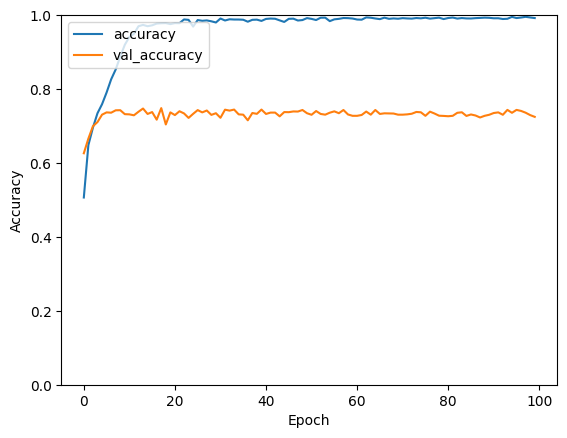

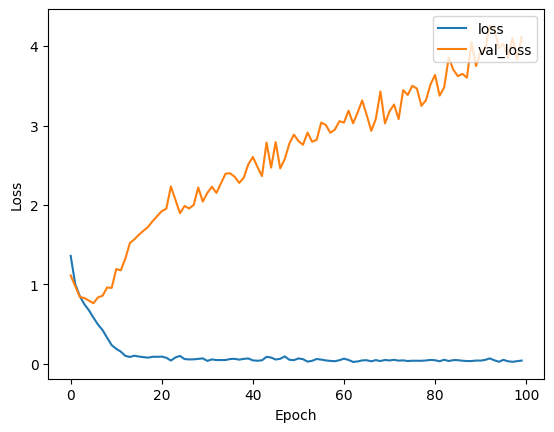

In [ ]:
plot_acc_loss(h_callback1)

In [ ]:
# save_model_and_weights(model1, score)

### Insights
* When the model is tested with the training data, it returns a relatively high accuracy and low loss function as compared to that of the validation data.
* The differences of accuracy and loss function between the train and test set are significant which shos that the modle is suffering from `overfitting`.

### Possible reasons of overfitting
* Lack of data points, unable to perform well on unseen data.
* If learning rate, a is too small, the loss function will arrive at the area "too close to" a minima, causing the model to be sensitive to "high-frequency" noise in the data and lead to `overfitting`. On the other note, if α is too large, it causes the optimizer to jump too far and misses the area near the local minima. This would be the extreme case of `underfitting`. Hence, a should be somewhere in between.

### Possible solutions to reduce overfitting
* Obtain more data
    - Implement`data augmentation`
* Perform regularization by adding dropout layer, early-stopping etc.
* Reduce model complexity

## Model 2
* Added Batch Normalization layer
* In order to address the overfitting issue mentioned before, Dropout layers after MaxPooling and Dense layers

### Why Batch Normalization?
* Batch Normalization adds a
 normalization layer after each convolutional layer. It reduces internal covariant shift and the dependence of gradients on the scale of the parameters or their initial values. It also allows the model to `converge much faster` in training and therefore also allows you to use `higher learning rates`.

### What to be aware of when using Dropout layers?
* Be aware that Dropout causes information to get lost. If you lose something in the first layer, it gets lost for the whole network. Therefore, a good practice is to start with a low dropout in the first layer and then gradually increase it.


In [ ]:
# 1st Convolution layer
model2 = Sequential()

# Block one
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model2.add(Conv2D(64, kernel_size= (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Dropout(0.5))

# 2nd Convolution layer
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(Dropout(0.5))

# 3rd Convolution layer
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(Flatten())

# Fully connected neural networks
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(num_labels, activation='softmax'))

# Compiling the model
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,917,000 (7.31 MB)

 Trainable params: 1,916,488 (7.31 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Training the model
h_callback2 = model2.fit(X_train, y_cat_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_validate, y_cat_validate),
                        shuffle=True)

Epoch 1/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.3890 - loss: 1.6534 - val_accuracy: 0.4982 - val_loss: 1.6270
Epoch 2/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5720 - loss: 1.2100 - val_accuracy: 0.6184 - val_loss: 1.1467
Epoch 3/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6322 - loss: 1.0535 - val_accuracy: 0.5198 - val_loss: 1.3748
Epoch 4/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6688 - loss: 0.9454 - val_accuracy: 0.6862 - val_loss: 0.8994
Epoch 5/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6971 - loss: 0.8643 - val_accuracy: 0.6687 - val_loss: 0.9635
Epoch 6/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7116 - loss: 0.8074 - val_accuracy: 0.7177 - val_loss: 0.8580
Epoch 7/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7307 - loss: 0.7480 - val_accuracy: 0.6941 - val_loss: 0.9197
Epoch 8/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7504 - loss: 0.6954 -

In [ ]:
# Evaluate model performance on test data
score = model2.evaluate(X_test, y_cat_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7542 - loss: 1.4963
Loss: 1.5083
Accuracy: 0.7518


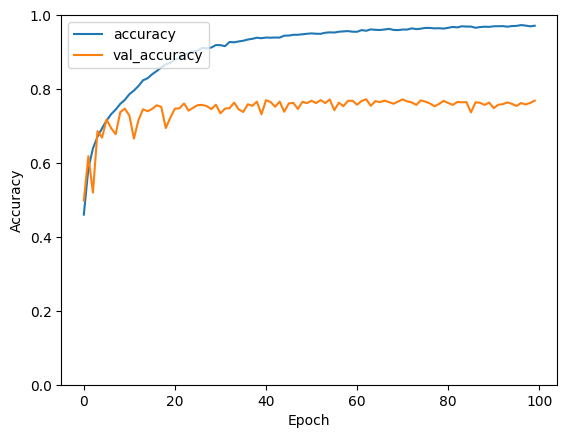

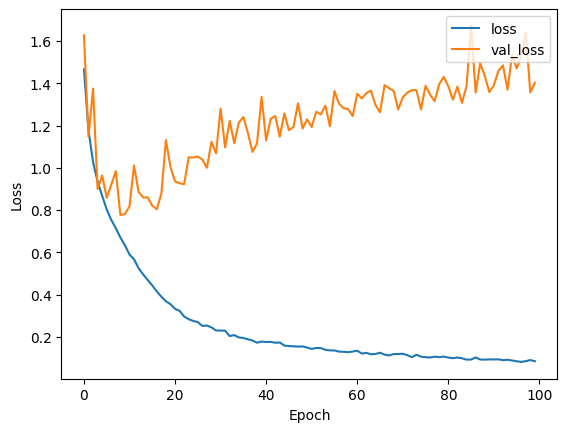

In [ ]:
plot_acc_loss(h_callback2)

In [ ]:
# save_model_and_weights(model2, score[1])

Model and weights are saved in separate files.


### Insights

## Model 3

## Data Augementation
* Data augmentation is useful to `improve performance` of machine learning models by forming new and different examples to train datasets that the model may see in the real world.

In [ ]:
def data_augmentation(X_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(X_train)
    return datagen

In [ ]:
def show_augmented_images(datagen, X_train, y_train):
    reverse_emotion_map = {v: k for k, v in emotion_map.items()}
    it = datagen.flow(X_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # plt.imshow(it.next()[0][0], cmap='gray')
        # label_index = np.argmax(y_train[i][0])
        # emotion_label = reverse_emotion_map[label_index]
        # plt.xlabel(emotion_label)
        # Retrieve and display the image
        batch = it.next()
        image = batch[0][0]
        label_index = np.argmax(batch[1][0])
        plt.imshow(image, cmap='gray')
        emotion_label = reverse_emotion_map[label_index]
        plt.xlabel(emotion_label)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    plt.show()

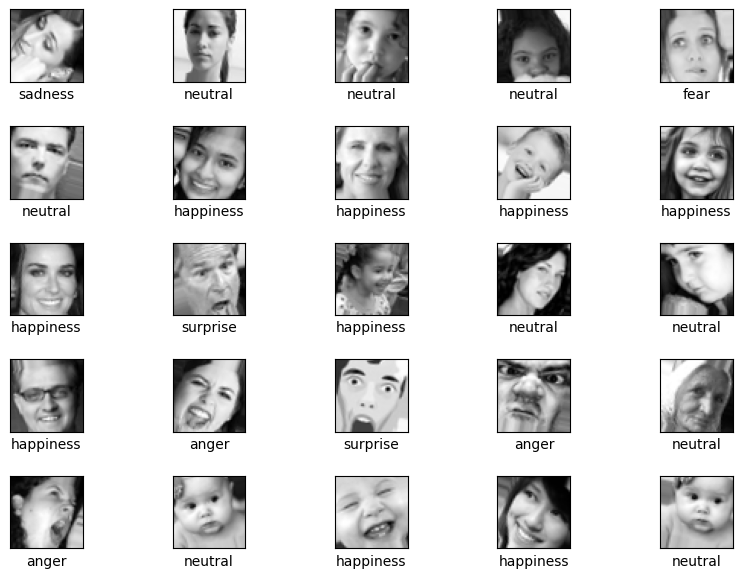

In [ ]:
datagen = data_augmentation(X_train)
show_augmented_images(datagen, X_train, y_cat_train)

In [ ]:
input_shape = (48, 48, 1)
classes = 8
num_features = 64

model3 = Sequential()

# 1st stage
model3.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=X_train.shape[1:]))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Conv2D(num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Dropout(0.5))

# 2nd stage
model3.add(Conv2D(num_features, (3, 3), activation='relu'))
model3.add(Conv2D(num_features, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd stage
model3.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))

# 4th stage
model3.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model3.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 5th stage
model3.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))
model3.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
model3.add(BatchNormalization())
model3.add(Activation(activation='relu'))

model3.add(Flatten())

# Fully connected neural networks
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(classes, activation='softmax'))

model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [ ]:
datagen = data_augmentation(X_train)
epochs = 100
batch_size = 64

In [ ]:
h_callback3 = model3.fit(datagen.flow(X_train, y_cat_train, batch_size=batch_size), epochs=epochs,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_data=(X_validate, y_cat_validate), verbose=1)

Epoch 1/100
443/443 [==============================] - 44s 68ms/step - loss: 0.3057 - accuracy: 0.3930 - val_loss: 0.3324 - val_accuracy: 0.3757
Epoch 2/100
443/443 [==============================] - 27s 60ms/step - loss: 0.2716 - accuracy: 0.5022 - val_loss: 0.2385 - val_accuracy: 0.5829
Epoch 3/100
443/443 [==============================] - 27s 61ms/step - loss: 0.2433 - accuracy: 0.5671 - val_loss: 0.2252 - val_accuracy: 0.6153
Epoch 4/100
443/443 [==============================] - 26s 59ms/step - loss: 0.2239 - accuracy: 0.6085 - val_loss: 0.2086 - val_accuracy: 0.6502
Epoch 5/100
443/443 [==============================] - 26s 60ms/step - loss: 0.2067 - accuracy: 0.6397 - val_loss: 0.2159 - val_accuracy: 0.6319
Epoch 6/100
443/443 [==============================] - 27s 60ms/step - loss: 0.1950 - accuracy: 0.6594 - val_loss: 0.1766 - val_accuracy: 0.6994
Epoch 7/100
443/443 [==============================] - 27s 60ms/step - loss: 0.1872 - accuracy: 0.6782 - val_loss: 0.1673 - val_ac

In [ ]:
# Evaluate model performance on test data
score = model3.evaluate(X_test, y_cat_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

111/111 [==============================] - 2s 18ms/step - loss: 0.1441 - accuracy: 0.8142
Loss: 0.1441
Accuracy: 0.8142


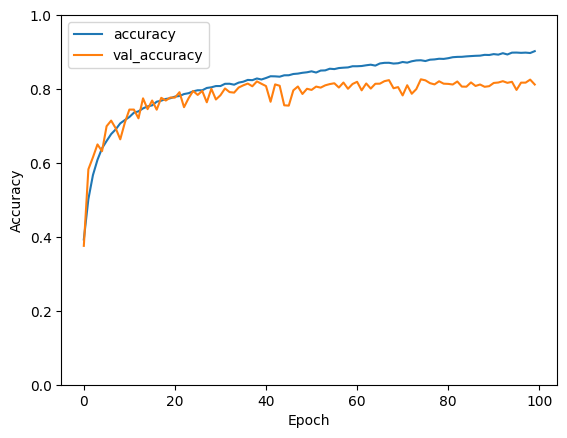

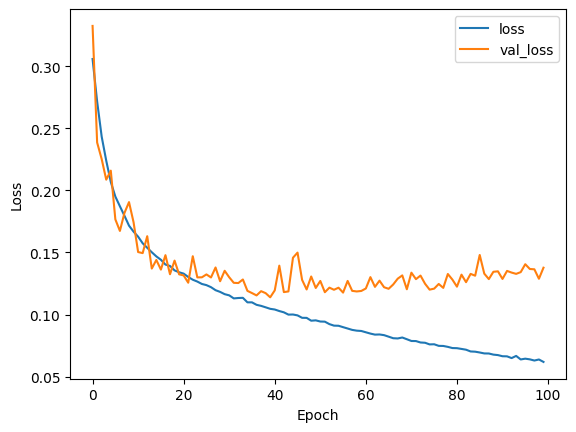

In [ ]:
plot_acc_loss(h_callback3)

In [ ]:
# save_model_and_weights(model3, score[1])

Model and weights are saved in separate files.


# Model 4 Pretrained Model: RESNET
* ResNet-152 introduced the concept of residual learning in which the subtraction of feature is learned from the input of that layer by using shortcut connections (directly connecting input of (n)th layer to some (n+x)th layer

Reference: https://lekhuyen.medium.com/a-quick-overview-of-resnet-models-f8ed277ae81e

In [32]:
# wp test resnet starts
import zipfile
import os

def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Example usage:
# zip_file_path = '/content/drive/MyDrive/SC1015-Mini-Project-Data/test-fer-resnet.zip'   # Path to your zip file
zip_file_path = '/content/drive/MyDrive/SC1015-Mini-Project-Data/data.zip'   # Path to your zip file
# extract_to = '/content/drive/MyDrive/SC1015-Mini-Project-Data'  # Directory where you want to extract the files
extract_to = '/content/data/'  # Directory where you want to extract the files

# Create the directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

unzip_file(zip_file_path, extract_to)


In [34]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
# valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [35]:
# base_dir = '/content/drive/MyDrive/SC1015-Mini-Project-Data'
base_dir = '/content/data'

In [36]:
# train_dataset  = train_datagen.flow_from_directory(directory = f"{base_dir}/train",
#                                                    target_size = (48,48),
#                                                    class_mode = 'categorical',
#                                                    subset = 'training',
#                                                    batch_size = 64)
train_dataset  = train_datagen.flow_from_directory(directory = f"{base_dir}/FER2013Train",
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22851 images belonging to 8 classes.


In [37]:
# valid_dataset = valid_datagen.flow_from_directory(directory = f"{base_dir}/train",
#                                                   target_size = (48,48),
#                                                   class_mode = 'categorical',
#                                                   subset = 'validation',
#                                                   batch_size = 64)
valid_dataset = valid_datagen.flow_from_directory(directory = f"{base_dir}/FER2013Valid",
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 713 images belonging to 8 classes.


In [38]:
# test_dataset = test_datagen.flow_from_directory(directory = f"{base_dir}/test",
#                                                   target_size = (48,48),
#                                                   class_mode = 'categorical',
#                                                   batch_size = 64)
test_dataset = test_datagen.flow_from_directory(directory = f"{base_dir}/FER2013Test",
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 3573 images belonging to 8 classes.


(48, 48, 3)
(1, 48, 48, 3)


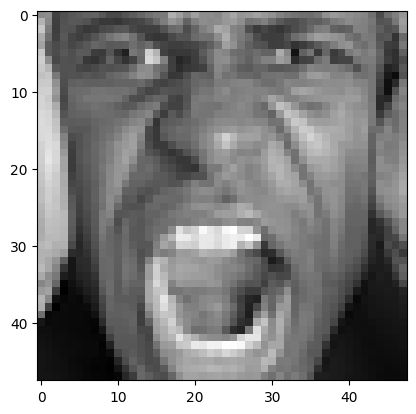

In [40]:
# from keras.preprocessing import image
# img = image.load_img(f"{base_dir}/test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
# img = np.array(img)
# plt.imshow(img)
# print(img.shape)

# img = np.expand_dims(img, axis=0)
# from keras.models import load_model
# print(img.shape)
from keras.preprocessing import image
img = image.load_img(f"{base_dir}/FER2013Test/Anger/fer0032225.png",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [41]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

94765736/94765736 [==============================] - 0s 0us/step


In [42]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [43]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dense(7,activation='softmax'))
model.add(Dense(8,activation='softmax'))

In [44]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

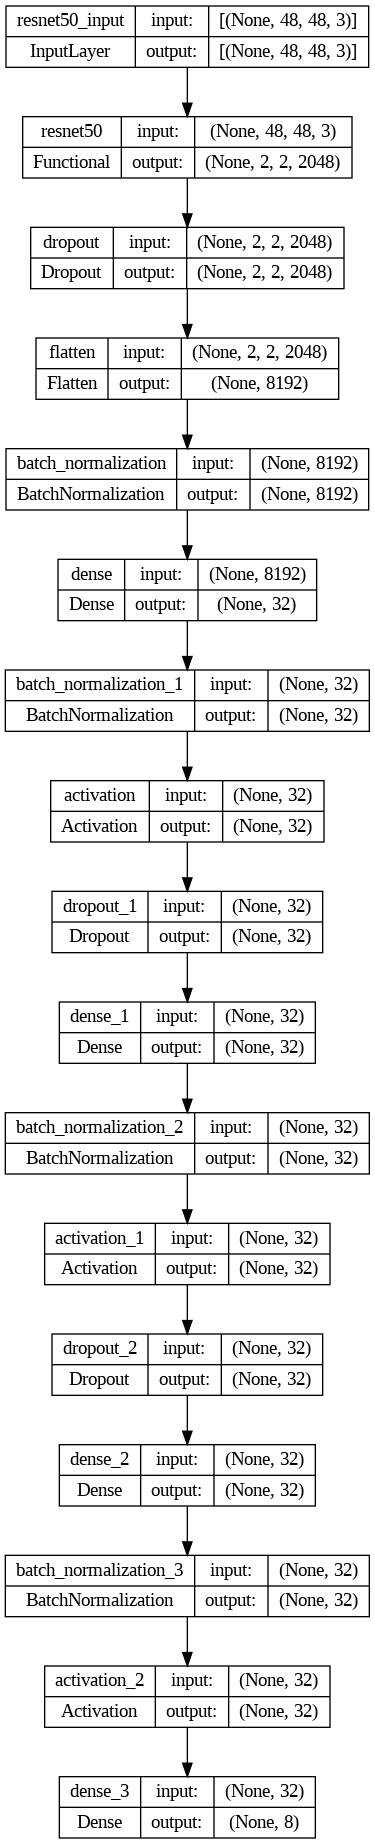

In [45]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model,  show_shapes=True,show_layer_names=True)


In [46]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [47]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      # tf.keras.metrics.Precision(name='precision'),
      # tf.keras.metrics.Recall(name='recall'),
      # tf.keras.metrics.AUC(name='auc'),
      #   f1_score,
]

In [48]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('/content/model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [49]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [50]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 60,verbose = 1,callbacks=[lrd,mcp,es])

# resnet test end
# dn run anything aft this cell

Epoch 1/60
358/358 [==============================] - 50s 106ms/step - loss: 1.8340 - accuracy: 0.8714 - val_loss: 1.6656 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 2/60
358/358 [==============================] - 36s 101ms/step - loss: 1.6410 - accuracy: 0.8735 - val_loss: 1.6229 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 3/60
358/358 [==============================] - 35s 98ms/step - loss: 1.6239 - accuracy: 0.8743 - val_loss: 1.6372 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 4/60
358/358 [==============================] - 36s 101ms/step - loss: 1.6145 - accuracy: 0.8743 - val_loss: 1.6250 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/60
358/358 [==============================] - 36s 101ms/step - loss: 1.6094 - accuracy: 0.8745 - val_loss: 1.6160 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/60
358/358 [==============================] - 36s 99ms/step - loss: 1.6042 - accuracy: 0.8748 - val_loss: 1.6173 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/60
358/358 [==============================] - 

In [56]:
# Evaluate model performance on test data
score = model.evaluate(test_dataset)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

56/56 [==============================] - 3s 43ms/step - loss: 1.5536 - accuracy: 0.8752
Loss: 1.5536
Accuracy: 0.8752


In [2]:
# Path to the file containing the model history
file_path = '/content/model_history.txt'

# Read the file content
with open(file_path, 'r') as file:
    history_lines = file.readlines()

# Initialize dictionaries to store the extracted data
history_data = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

# Process each line in the file to extract the needed data
for line in history_lines:
    if "loss:" in line:
        # Extract data
        parts = line.split("-")
        loss = float(parts[2].strip().split(":")[1].strip())
        accuracy = float(parts[3].strip().split(":")[1].strip())
        val_loss = float(parts[4].strip().split(":")[1].strip())
        val_accuracy = float(parts[5].strip().split(":")[1].strip())

        # Store the data
        history_data['loss'].append(loss)
        history_data['accuracy'].append(accuracy)
        history_data['val_loss'].append(val_loss)
        history_data['val_accuracy'].append(val_accuracy)

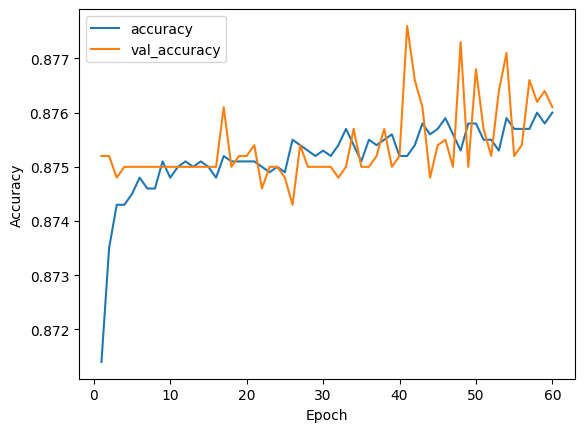

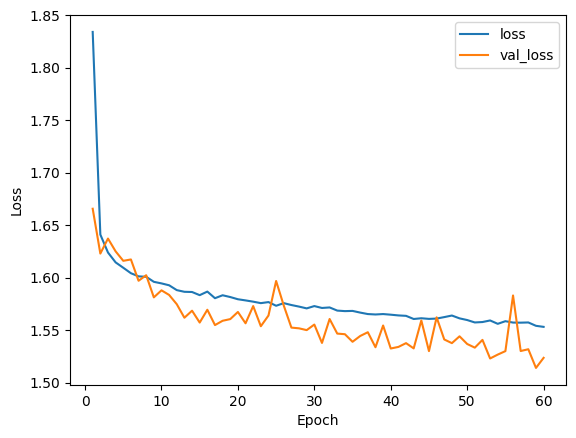

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(range(1, 61), history_data['accuracy'], label='accuracy')
plt.plot(range(1, 61), history_data['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(range(1, 61), history_data['loss'], label='loss')
plt.plot(range(1, 61), history_data['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

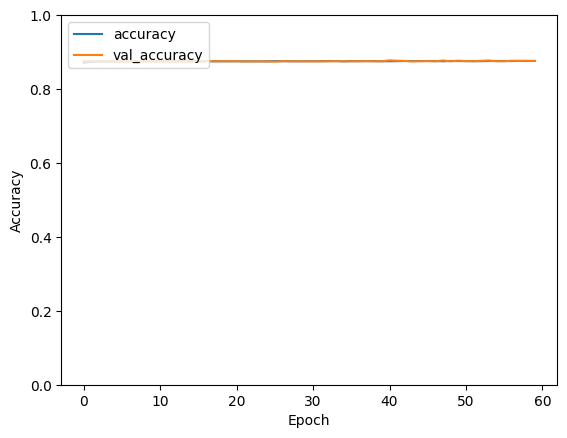

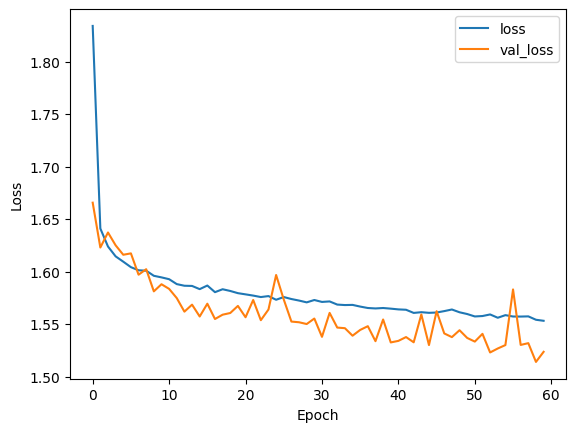

In [55]:
plot_acc_loss(history)

In [ ]:
# save_model_and_weights(model, score[1])

In [ ]:
# convert b&w to rgb
NUM_CLASSES = 8
IMG_SHAPE = (120, 120, 3)
BATCH_SIZE = 8
base_dir = '/content/drive/MyDrive/SC1015-Mini-Project-Data/content/data'

def load_data(base_dir, img_height=120, img_width=120, batch_size=32):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{base_dir}/FER2013Train",
        labels='inferred',
        label_mode='int',  # 'int' for sparse categorical cross-entropy
        class_names=["Neutral", "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Contempt"],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=123,
        validation_split=0.2,
        subset="training",
        interpolation='bilinear'
    )

    valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{base_dir}/FER2013Valid",
        labels='inferred',
        label_mode='int',
        class_names=["Neutral", "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Contempt"],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=123,
        validation_split=0.2,
        subset="validation",
        interpolation='bilinear'
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{base_dir}/FER2013Test",
        labels='inferred',
        label_mode='int',
        class_names=["Neutral", "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Contempt"],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=False,
        interpolation='bilinear'
    )

    return train_ds, valid_ds, test_ds

In [ ]:
def dataset_to_array(dataset):
    """ Convert a tf.data.Dataset into images and labels arrays. """
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert the batch of images to NumPy
        labels.append(label_batch.numpy())  # Convert the batch of labels to NumPy
    return np.concatenate(images), np.concatenate(labels)

In [ ]:
# Load your datasets

X_train_dataset, X_valid_dataset, X_test_dataset = load_data(base_dir)

Found 7204 files belonging to 8 classes.
Using 5764 files for training.
Found 3579 files belonging to 8 classes.
Using 715 files for validation.
Found 3573 files belonging to 8 classes.


In [ ]:
# Convert datasets to arrays
X_train, y_train = dataset_to_array(X_train_dataset)
X_valid, y_valid = dataset_to_array(X_valid_dataset)
X_test, y_test = dataset_to_array(X_test_dataset)

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

print("Shape of train_sample: {}".format(X_train.shape))
print("Shape of train_label: {}".format(y_train.shape))
print("Shape of valid_sample: {}".format(X_valid.shape))
print("Shape of valid_label: {}".format(y_valid.shape))
print("Shape of test_sample: {}".format(X_test.shape))
print("Shape of test_label: {}".format(y_test.shape))

In [ ]:
# Convert datasets to arrays
X_train, y_train = dataset_to_array(X_train_dataset)
X_valid, y_valid = dataset_to_array(X_valid_dataset)
X_test, y_test = dataset_to_array(X_test_dataset)

KeyboardInterrupt: 

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

print("Shape of train_sample: {}".format(X_train.shape))
print("Shape of train_label: {}".format(y_train.shape))
print("Shape of valid_sample: {}".format(X_valid.shape))
print("Shape of valid_label: {}".format(y_valid.shape))
print("Shape of test_sample: {}".format(X_test.shape))
print("Shape of test_label: {}".format(y_test.shape))

Shape of train_sample: (22847, 120, 120, 3)
Shape of train_label: (22847,)
Shape of valid_sample: (715, 120, 120, 3)
Shape of valid_label: (715,)
Shape of test_sample: (3573, 120, 120, 3)
Shape of test_label: (3573,)


In [ ]:
print(y_train)

NameError: name 'y_train' is not defined

In [ ]:
aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

generator_val = ImageDataGenerator()

In [ ]:
aug_train.fit(X_train)
generator_val.fit(X_validate)

In [ ]:
from keras.applications.resnet import ResNet152
from keras.callbacks import *

IMG_WIDTH = 48
IMG_HEIGHT = 48

model4 = Sequential()

pretrained_model = ResNet152(include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=8,
                                        weights=None)
#for layer in pretrained_model.layers:
#        layer.trainable=False

model4.add(pretrained_model)
#model.add(Flatten())
model4.add(GlobalAveragePooling2D())
model4.add(Dropout(0.2))
# output layer
model4.add(Dense(8, activation='softmax'))
# compile the model
model4.compile(optimizer=Adam(learning_rate=0.0005),loss=SparseCategoricalCrossentropy(),metrics=['accuracy'])
model4.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2, 2, 2048)        58370944  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 58387336 (222.73 MB)
Trainable params: 58235912 (222.15 MB)
Non-trainable params: 151424 (591.50 KB)
_________________________________________________________________


In [ ]:
HIST_NAME = 'model/ResNet152_Hist.log'
SAVE_NAME = 'model/ResNet152.h5'
HIST_PATH = os.path.join(DRIVE_PATH, HIST_NAME)
SAVE_PATH = os.path.join(DRIVE_PATH, SAVE_NAME)

# checkpoint
checkpoint = ModelCheckpoint(
    SAVE_PATH,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)
# earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 7,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
# learning_rate_schedule
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [ ]:
history = model4.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),
                    validation_data=generator_val.flow(X_validate, y_cat_validate, batch_size=32),
                    steps_per_epoch=len(y_train) // 32,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint, learning_rate_reduction, CSVLogger(HIST_PATH)])



Epoch 1/50
 13/713 [..............................] - ETA: 3:42:02 - loss: 3.2154 - accuracy: 0.2837

In [ ]:
# display some of the predicted emotions


In [ ]:
# saving the model to use it later on
fer_json = model4.to_json()
with open("/content/fer.json", "w") as json_file:
    json_file.write(fer_json)
model4.save_weights("/content/fer.h5")